# Importing libraries

In [1]:
!pip install catboost

In [2]:
# for data manipulation
import pandas as pd
import numpy as np
import re
import string
import random

# for text manipulation
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import  WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')


# for machine learning
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier 

# others
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")
import pickle
from tqdm import tqdm
import time
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv
/kaggle/input/emotion-dict/Emoticon_Dict.p


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# path = "/content/drive/MyDrive/Colab Notebooks/data/"

In [5]:
# eliminate randomness in calculations
random.seed(0)
np.random.seed(0)

# Explorating data


In [6]:
# data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1",
#                    names=["category", "ids", "date", "flag", "user", "text"])

In [7]:
data = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1",
                   names=["category", "ids", "date", "flag", "user", "text"])

In [8]:
data.shape

(1600000, 6)

In [9]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   category  1600000 non-null  int64 
 1   ids       1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   flag      1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [10]:
data.head()

,category,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [11]:
data.category.unique()

array([0, 4])

In [12]:
data["category"].value_counts()

0    800000
4    800000
Name: category, dtype: int64

# Data cleaning


Delete **ids**, **flag**, **date** and **user** columns. These columns are very unique and they don't make any contribution to classify text properly, in my opinion. 


In [13]:
data_needed = data[["category", "text"]]
data_needed["category"].loc[data_needed["category"] == 4] = 1

data_needed.head()

,category,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


Let's reduce our data in order to make calculations faster.

In [14]:
# I think it's better to shuffle data
reduced_data = data_needed.sample(frac=0.3).reset_index(drop=True)
print(reduced_data.shape)
reduced_data.head()

(480000, 2)


,category,text
0,0,wants to compete! i want hard competition! i w...
1,0,It seems we are stuck on the ground in Amarill...
2,0,where the f are my pinking shears? rarararrrar...
3,0,0ff t0 tHE MEEtiN.. i HAtE WhEN PPl V0lUNtEER...
4,1,@ reply me pls


In [15]:
# try:
#   with open('reduced_data.pickle', 'rb') as f:
#     reduced_data = pickle.load(f)
# except:
#   with open("reduced_data.pickle", 'wb') as f:
#     pickle.dump(reduced_data, f)
#   with open('reduced_data.pickle', 'rb') as f:
#     reduced_data = pickle.load(f)

## Text cleaning

In [16]:
# downloading stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
print(r"The number of stopwords -", len(stop_words))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
The number of stopwords - 179


In [17]:
# dictionary with emotions. It's needed to convert emotions to words
with open('/kaggle/input/emotion-dict/Emoticon_Dict.p', 'rb') as fp:
    emoticon_dict = pickle.load(fp)

In [18]:
def full_cleaning(df: pd.DataFrame, column: str, emotions: dict, batch_size: int):
  df_copy = df.copy()

  # converting emotions to words
  for emot in emotions:
    df_copy[column] =df_copy[column].apply(lambda x: re.sub(u'('+emot+')', " ".join(emotions[emot].replace(",","").split()), x))
  print("emotions have been coverted to words")
  
  # convert all text to lowcase
  df_copy[column] = df_copy[column].str.lower()
  print("all test is lowcase")
  
  # delete URLs from text
  df_copy[column] = df_copy[column].str.replace(r"http\S+|www\S+|https\S+", "")
  print("URLs have been deleted")

  # remove references(@) to users, hashtags(#) and quotes(&)
  df_copy[column] = df_copy[column].str.replace(r"\@\S+|\#|\&\S+", "")
  print("references, hashtags and quotes have been deleted")

  # delete punctuation
  df_copy[column] = df_copy[column].apply(lambda x: x.translate(str.maketrans("", "", string.punctuation)))
  print("sins of punctuation have been deleted")

  # delete blanks at the beginning and at the end of a string
  df_copy[column] = df_copy[column].str.replace(r"^\s", "")
  df_copy[column] = df_copy[column].str.replace(r"^\s$", "")
  print("blanks are deleted")

  # tokenize our text
  df_copy[column] = df_copy[column].apply(lambda x: word_tokenize(x))
  print("text has been tokenized")

  # filter words that there are in stopwords
  df_copy[column] = df_copy[column].apply(lambda x: [word for word in x if word not in stop_words])
  print("stopwords have been deleted")

  # lemmatazing
  lemmer = spacy.load("en_core_web_sm")
  # we need to join words in list into string in order to use spacy lemmatizer
  df_copy[column] = df_copy[column].apply(lambda x: " ".join(x))

  for pos in tqdm(range(0, len(df_copy), batch_size)):
    df_copy[column][pos: pos + batch_size] = df_copy[column][pos: pos + batch_size].apply(lambda x: [token.lemma_ for token in lemmer(x)])
  print("words have been lemmatized")

  # finally join the words
  df_copy[column] = df_copy[column].apply(lambda x: " ".join(x))

  return df_copy

**There is an opinion that we should not delete stopwords  and make words in lowcase for tweets. So we should  check this hypothesis.**

In [19]:
# I don't convert text to lowcase
# I don't delete stopwords
def not_full_cleaning(df: pd.DataFrame, column: str, emotions: dict, batch_size: int):
  df_copy = df.copy()

  # converting emotions to words
  for emot in emotions:
    df_copy[column] =df_copy[column].apply(lambda x: re.sub(u'('+emot+')', " ".join(emotions[emot].replace(",","").split()), x))
  print("emotions have been coverted to words")
  
  # # convert all text to lowcase
  # df_copy[column] = df_copy[column].str.lower()
  # print("all test is lowcase")
  
  # delete URLs from text
  df_copy[column] = df_copy[column].str.replace(r"http\S+|www\S+|https\S+", "")
  print("URLs have been deleted")

  # remove references(@) to users, hashtags(#) and quotes(&)
  df_copy[column] = df_copy[column].str.replace(r"\@\S+|\#|\&\S+", "")
  print("references, hashtags and quotes have been deleted")

  # delete punctuation
  df_copy[column] = df_copy[column].apply(lambda x: x.translate(str.maketrans("", "", string.punctuation)))
  print("sins of punctuation have been deleted")

  # delete blanks at the beginning and at the end of a string
  df_copy[column] = df_copy[column].str.replace(r"^\s", "")
  df_copy[column] = df_copy[column].str.replace(r"^\s$", "")
  print("blanks are deleted")

  # tokenize our text
  df_copy[column] = df_copy[column].apply(lambda x: word_tokenize(x))
  print("text has been tokenized")

  # # filter words that there are in stopwords
  # df_copy[column] = df_copy[column].apply(lambda x: [word for word in x if word not in stop_words])
  # print("stopwords have been deleted")

  # lemmatazing
  lemmer = spacy.load("en_core_web_sm")
  # we need to join words in list into string in order to use spacy lemmatizer
  df_copy[column] = df_copy[column].apply(lambda x: " ".join(x))

  for pos in tqdm(range(0, len(df_copy), batch_size)):
    df_copy[column][pos: pos + batch_size] = df_copy[column][pos: pos + batch_size].apply(lambda x: [token.lemma_ for token in lemmer(x)])
  print("words have been lemmatized")

  # finally join the words
  df_copy[column] = df_copy[column].apply(lambda x: " ".join(x))

  return df_copy

In [20]:
%%time
cleaned_data_full = full_cleaning(reduced_data, "text", emoticon_dict, 4000)

emotions have been coverted to words
all test is lowcase
URLs have been deleted
references, hashtags and quotes have been deleted
sins of punctuation have been deleted
blanks are deleted
text has been tokenized
stopwords have been deleted


100%|██████████| 120/120 [55:11<00:00, 27.60s/it]


words have been lemmatized
CPU times: user 1h 2min, sys: 1.46 s, total: 1h 2min 2s
Wall time: 1h 2min 2s


In [21]:
# try:
#   with open('preprocessed_data.pickle', 'rb') as f:
#     cleaned_data_full = pickle.load(f)
# except:
#   with open("preprocessed_data.pickle", 'wb') as f:
#     pickle.dump(cleaned_data_full, f)
#   with open('preprocessed_data.pickle', 'rb') as f:
#     cleaned_data_full = pickle.load(f)

In [22]:
print(cleaned_data_full.shape)
cleaned_data_full.head()

(480000, 2)


,category,text
0,0,wants compete want hard competition want rally...
1,0,seem stuck ground amarillo put ground stop fli...
2,0,f pink shear rarararrrarararrbabyproofe cut st...
3,0,0ff t0 meetin hate ppl v0lunteer free timegrrr
4,1,reply pls


In [23]:
%%time
not_full_cleaned_data = not_full_cleaning(reduced_data, "text", emoticon_dict, 4000)

emotions have been coverted to words
URLs have been deleted
references, hashtags and quotes have been deleted
sins of punctuation have been deleted
blanks are deleted
text has been tokenized


100%|██████████| 120/120 [1:03:06<00:00, 31.56s/it]


words have been lemmatized
CPU times: user 1h 9min 50s, sys: 1.63 s, total: 1h 9min 51s
Wall time: 1h 9min 52s


In [24]:
# try:
#   with open('preprocessed_data_not_full.pickle', 'rb') as f:
#     not_full_cleaned_data = pickle.load(f)
# except:
#   with open("preprocessed_data_not_full.pickle", 'wb') as f:
#     pickle.dump(not_full_cleaned_data, f)
#   with open('preprocessed_data_not_full.pickle', 'rb') as f:
#     not_full_cleaned_data = pickle.load(f)

In [25]:
print(not_full_cleaned_data.shape)
not_full_cleaned_data.head()

(480000, 2)


,category,text
0,0,want to compete I want hard competition I want...
1,0,it seem we be stick on the ground in Amarillo ...
2,0,where the f be my pinking shear rarararrrarara...
3,0,0ff t0 the meetin I hate when PPl V0lUNtEER my...
4,1,reply I pls


# Choosing the best model

## Splitting the dataset

As our dataset is large and I don't have so much computatuinal power I need to take just small amount of data for training.

In [26]:
# creating dataset for tesing a model
for_test = cleaned_data_full.sample(frac=0.01).reset_index(drop=True)
print(for_test.shape)

X_test = for_test["text"]
y_test = for_test["category"]
print(X_test.shape, "\n", y_test.shape)

other = cleaned_data_full[~(cleaned_data_full["text"].isin(X_test))]
print(other.shape)

(4800, 2)
(4800,) 
 (4800,)
(466036, 2)


In [27]:
def choosing_best_model(main_df: pd.DataFrame, X_val:pd.Series, y_val:pd.Series, num_df=10):
  
  # splitting for train data
  dataframes_for_estim = dict()

  # create several dataframes in order to have fairer estimation
  for num in range(num_df):
    exec(f'estimate_data{num} = main_df.sample(frac=0.04).reset_index(drop=True)')
    dataframes_for_estim[num] = f"estimate_data{num}"
  
  # save train and test for different dataframes
  train_test_dict = dict()

  for key,value in dataframes_for_estim.items():
    exec(f"X_train{key} = eval(value)['text']")
    exec(f"y_train{key} = eval(value)['category']")
    train_test_dict[key] = tuple((f"X_train{key}", f"y_train{key}"))
  
  # create pipelines for each model
  tf_idf_vec = TfidfVectorizer()
  pipe_dict = list()
  
  pipelines = ["logistic_reg", "svm", "naive_bayes", "RF", "cat_boost"]
  models = ["LogisticRegression()", "SVC()", "MultinomialNB()", "RandomForestClassifier()", "CatBoostClassifier(logging_level='Silent')"]

  # save pipelines for each model
  # eval() allows us to convert string to variable
  for num in range(len(pipelines)):
    exec(f"pipe_{pipelines[num]} = Pipeline([('tfidf', TfidfVectorizer()),(pipelines[num], eval(models[num]))])")
    pipe_dict.append(f"pipe_{pipelines[num]}")

  
  # estimating models
  accuracy_dict = dict()
  f1_dict = dict()
  
  for i in range(len(models)):
    start = time.time()
    print(i)
    accuracy_list = []
    f1_list = []
    for j in range(len(train_test_dict)):
      # training model
      eval(pipe_dict[i]).fit(eval(train_test_dict[j][0]), eval(train_test_dict[j][1]))
      # making predictions
      pred = eval(pipe_dict[i]).predict(X_val)
    
      accuracy = accuracy_score(y_val, pred)
      accuracy_list.append(accuracy)

      f1 = f1_score(y_val, pred)
      f1_list.append(f1)

    accuracy_dict[pipelines[i]] = accuracy_list
    f1_dict[pipelines[i]] = f1_list
    stop = time.time()
    print(f"Время обучения {pipelines[i]} составляет {stop - start}")

  return accuracy_dict, f1_dict



  

In [28]:
y_test

0       0
1       1
2       1
3       1
4       0
       ..
4795    0
4796    0
4797    0
4798    0
4799    1
Name: category, Length: 4800, dtype: int64

In [29]:
%%time
acc, f1_m = choosing_best_model(other, X_test, y_test)


0
Время обучения logistic_reg составляет 11.740012645721436
1
Время обучения svm составляет 810.0854918956757
2
Время обучения naive_bayes составляет 3.5837461948394775
3
Время обучения RF составляет 298.67607259750366
4
Время обучения cat_boost составляет 1208.2296993732452
CPU times: user 1h 11min 35s, sys: 13min 51s, total: 1h 25min 26s
Wall time: 38min 52s


In [30]:
y_test.unique()

array([0, 1])

In [31]:
# try:
#   with open(path + 'accuracy.pickle', 'rb') as f:
#     acc = pickle.load(f)
# except:
#   with open(path + "accuracy.pickle", 'wb') as f:
#     pickle.dump(acc, f)
#   with open(path + 'accuracy.pickle', 'rb') as f:
#     acc = pickle.load(f)

In [32]:
# try:
#   with open(path + 'f1.pickle', 'rb') as f:
#     f1_m = pickle.load(f)
# except:
#   with open(path + "f1.pickle", 'wb') as f:
#     pickle.dump(f1_m, f)
#   with open(path + 'f1.pickle', 'rb') as f:
#     f1_m = pickle.load(f)

In [33]:
f1 = pd.DataFrame(f1_m)
f1.head()

,logistic_reg,svm,naive_bayes,RF,cat_boost
0,0.752267,0.755262,0.735338,0.726295,0.753201
1,0.750155,0.751126,0.726318,0.738716,0.752705
2,0.747466,0.749068,0.720106,0.732101,0.749704
3,0.744785,0.751426,0.720950,0.731697,0.747771
4,0.753593,0.754038,0.739102,0.737836,0.746085


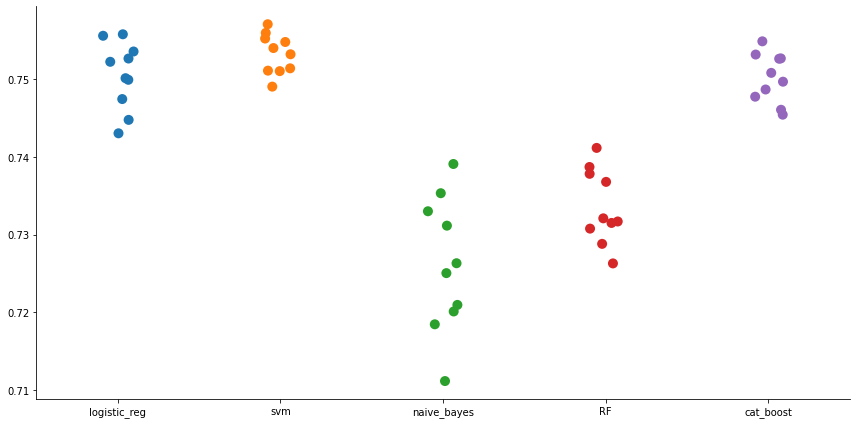

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.catplot(data=f1, height=6, aspect=2, s=10)
  

We see that the results of logistic regression and support vector machine are close enough but the variance of the latest model is smaller. 

I choose logistic regression as "the best model" as the results are quite well and the speed of fitting is very high.

# Tuning the model

## Without stopwords

In [35]:
# creating dataset for GridSearch
for_grid = other.sample(frac=0.04).reset_index(drop=True)
print(for_grid.shape)
for_grid.head()

(18641, 2)


,category,text
0,1,tim actually star new red robin series next week
1,0,even vip ticket yesterday there s way get time...
2,1,get paper
3,1,everyone amazing day tomorrowor today lol u fi...
4,1,tryin 2 get pic upload


In [36]:
for_grid_X = for_grid["text"]
for_grid_y = for_grid["category"]

for_grid_y.head()


0    1
1    0
2    1
3    1
4    1
Name: category, dtype: int64

In [37]:
for_grid_X.head()

0     tim actually star new red robin series next week
1    even vip ticket yesterday there s way get time...
2                                            get paper
3    everyone amazing day tomorrowor today lol u fi...
4                               tryin 2 get pic upload
Name: text, dtype: object

In [38]:
cleaned_data_full_X = cleaned_data_full["text"]
cleaned_data_full_y = cleaned_data_full["category"]

cleaned_data_full_X_train, cleaned_data_full_X_test, cleaned_data_full_y_train, cleaned_data_full_y_test = train_test_split(cleaned_data_full_X,\
                                                                                                        cleaned_data_full_y, test_size=0.3, random_state=0)
print(cleaned_data_full_X_train.shape, cleaned_data_full_y_train.shape,"\n", cleaned_data_full_X_test.shape, cleaned_data_full_y_test.shape)


(336000,) (336000,) 
 (144000,) (144000,)


In [39]:
not_full_cleaned_data_X = not_full_cleaned_data["text"]
not_full_cleaned_data_y = not_full_cleaned_data["category"]

not_full_cleaned_data_X_train, not_full_cleaned_data_X_test, not_full_cleaned_data_y_train, not_full_cleaned_data_y_test = train_test_split(not_full_cleaned_data_X,\
                                                                                                        not_full_cleaned_data_y, test_size=0.3, random_state=0)
print(not_full_cleaned_data_X_train.shape, not_full_cleaned_data_y_train.shape,"\n", not_full_cleaned_data_X_test.shape, not_full_cleaned_data_y_test.shape)


(336000,) (336000,) 
 (144000,) (144000,)


### Logistic regression

Firstly we have to find the best hyperparametes of the algorithm

In [40]:
%%time
# IT'S IMPORTANT TO USE THE NAME OF A MODEL FROM PIPELINE + __ + a parameter name !!!!!!!!!!!!!
pipe_log = Pipeline([("tfidf", TfidfVectorizer()),
                    ("logistic_clf", LogisticRegression())])
log_param = {"logistic_clf__penalty": ["none","elasticnet"],
             "logistic_clf__C": [1, 10, 100, 500],
             "logistic_clf__max_iter": [500, 200, 1000, 2000]}

log_grid = GridSearchCV(pipe_log, log_param, scoring="f1", cv=5)
log_grid.fit(for_grid_X, for_grid_y)

CPU times: user 20min 40s, sys: 25min 57s, total: 46min 38s
Wall time: 12min 25s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('logistic_clf', LogisticRegression())]),
             param_grid={'logistic_clf__C': [1, 10, 100, 500],
                         'logistic_clf__max_iter': [500, 200, 1000, 2000],
                         'logistic_clf__penalty': ['none', 'elasticnet']},
             scoring='f1')

In [41]:
log_grid.best_score_

0.6450559740463807

In [42]:
log_grid.best_params_

{'logistic_clf__C': 1,
 'logistic_clf__max_iter': 200,
 'logistic_clf__penalty': 'none'}

In [43]:
%%time
best_log_pipe = Pipeline([("tfidf", TfidfVectorizer()),
             ("logistic_clf", LogisticRegression(penalty='none', C=1, max_iter=200))])
best_log_pipe.fit(cleaned_data_full_X_train, cleaned_data_full_y_train)

CPU times: user 57.5 s, sys: 58.2 s, total: 1min 55s
Wall time: 33.6 s


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('logistic_clf',
                 LogisticRegression(C=1, max_iter=200, penalty='none'))])

In [44]:
pred = best_log_pipe.predict(cleaned_data_full_X_test)

f1_best_log = f1_score(cleaned_data_full_y_test, pred)

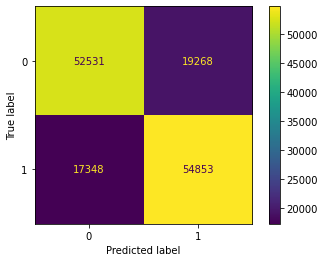

In [45]:
plot_confusion_matrix(best_log_pipe, cleaned_data_full_X_test, cleaned_data_full_y_test)

In [46]:
print(classification_report(cleaned_data_full_y_test, pred))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74     71799
           1       0.74      0.76      0.75     72201

    accuracy                           0.75    144000
   macro avg       0.75      0.75      0.75    144000
weighted avg       0.75      0.75      0.75    144000



Let's try to change the threshold and see whether the result is improved.

In [47]:
threshs = np.arange(0.0, 1.0, 0.1)
def searching_for_best_thresh(X_train, y_train, X_test, y_test, thresh_list):
  log = Pipeline([("tfidf", TfidfVectorizer()),
             ("logistic_clf", LogisticRegression(penalty='none', C=1, max_iter=200))])
  log.fit(X_train, y_train)
  
  max_f1 = 0
  
  for thresh in tqdm(thresh_list):
    pred = np.where(log.predict_proba(X_test)[:,1] > thresh, 1, 0)
    f1 = f1_score(y_test, pred)
    if f1 > max_f1:
      max_f1 = f1
      best_thresh = thresh
  return (max_f1, best_thresh)

In [48]:
%%time
best_thresh, max_f1 = searching_for_best_thresh(cleaned_data_full_X_train, cleaned_data_full_y_train, cleaned_data_full_X_test, cleaned_data_full_y_test,\
                                        threshs)


100%|██████████| 10/10 [00:20<00:00,  2.03s/it]

CPU times: user 1min 18s, sys: 1min, total: 2min 18s
Wall time: 54.7 s


In [49]:
best_thresh

0.7603575525929925

In [50]:
max_f1

0.30000000000000004

## With stopwords

In [51]:
%%time
best_log_pipe_with_sw = Pipeline([("tfidf", TfidfVectorizer()),
             ("logistic_clf", LogisticRegression(penalty='none', C=1, max_iter=200))])
best_log_pipe_with_sw.fit(not_full_cleaned_data_X_train, not_full_cleaned_data_y_train)

CPU times: user 1min 1s, sys: 1min, total: 2min 1s
Wall time: 36.5 s


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('logistic_clf',
                 LogisticRegression(C=1, max_iter=200, penalty='none'))])

In [52]:
pred_with_sw = best_log_pipe_with_sw.predict(not_full_cleaned_data_X_test)

f1_best_log_with_sw = f1_score(not_full_cleaned_data_y_test, pred_with_sw)

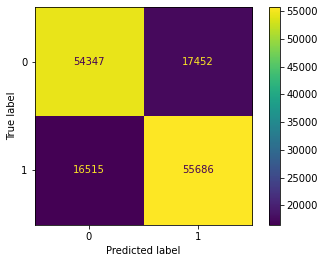

In [53]:
plot_confusion_matrix(best_log_pipe_with_sw, not_full_cleaned_data_X_test, not_full_cleaned_data_y_test)

In [54]:
not_full_cleaned_data_X_test

433741                      yeah thank go home today though
5472                                     I call she say now
475048    bowling at 300 and the only single girl in my ...
242080    sound like an excellent weekend except for wor...
199089                                 YAY Glad you like em
                                ...                        
193520                              aww wrong spelling fete
130591    ahh I too he be my fave though the name kinda ...
357509    wisdom 4uskeptical annoy undecided uneasy or h...
381694               do not stop Believin Glee Cast love it
185377    I need to get my workout on tomorrow morning I...
Name: text, Length: 144000, dtype: object

In [55]:
print(classification_report(not_full_cleaned_data_y_test, pred_with_sw))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76     71799
           1       0.76      0.77      0.77     72201

    accuracy                           0.76    144000
   macro avg       0.76      0.76      0.76    144000
weighted avg       0.76      0.76      0.76    144000



In [56]:
%%time
best_thresh_with_sw, max_f1_with_sw = searching_for_best_thresh(not_full_cleaned_data_X_train, not_full_cleaned_data_y_train, not_full_cleaned_data_X_test, not_full_cleaned_data_y_test,\
                                        threshs)


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]

CPU times: user 1min 30s, sys: 1min 2s, total: 2min 32s
Wall time: 1min 4s


In [57]:
best_thresh_with_sw

0.7729738144907682

In [58]:
max_f1_with_sw

0.30000000000000004

# Conclusion

It's true that the f1-score of the model based on corpus with stopwords is a litle bit higher than without stopwords. The difference is anout 0.1.

To imrove the performace we should try to reduce the amount of dimensions and feed the data to more advanced models like Gradient boosting. In addition, one can try to use special libraries which deal with tweets and compare data cleaning/preprocessing with the used libraries in this notebook.